In [25]:
# Importing libraries
from typing import List, Tuple, Dict, List
import numpy as np

In [26]:
class VectorModel:
    
    def __init__(self, vector_dict: Dict[str, np.ndarray]):
        self.index = dict()
        self.reverse_index = dict()
        arrays = []
        for idx, item in enumerate(vector_dict.items()):
            word, vec = item
            arrays.append(vec)
            self.index[word] = idx
            self.reverse_index[idx] = word
        self.embeddings = np.stack(arrays)
        
    def embed(self, word: str) -> np.ndarray:
        if word in self.index:
            return self.embeddings[self.index[word]]
    
    def vector_size(self) -> int:
        return self.embeddings.shape[1]
    
    def cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    def most_similar(self, word: str, top_n: int=5) -> List[Tuple[str, float]]:
        if word not in self.index:
            return None
        
        sims = []
        for idx in range(len(self.index)):
            sims.append(self.cosine_similarity(self.embed(word), self.embeddings[idx]))
        sim = np.array(sims)
        top_n += 1
        topn_indices = list(np.argpartition(sims, -top_n)[-top_n:])
        if self.index[word] in topn_indices:
            topn_indices.remove(self.index[word])
        else:
            topn_indices = topn_indices[:-1]
        
        result = []
        for idx in topn_indices:
            result.append((self.reverse_index[idx], sim[idx]))
        return sorted(result, key=lambda x: -x[1])
        
    def most_similar_vec(self, vec: np.ndarray, top_n: int=5) -> List[Tuple[str, float]]:
       
        sims = []
        for idx in range(len(self.index)):
            sims.append(self.cosine_similarity(vec, self.embeddings[idx]))
        sim = np.array(sims)
        topn_indices = list(np.argpartition(sims, -top_n)[-top_n:])
        
        result = []
        for idx in topn_indices:
            result.append((self.reverse_index[idx], sim[idx]))
        return sorted(result, key=lambda x: -x[1])

In [27]:
class SemanticAxis:
    
    def __init__(self, words, model: VectorModel):
        """
        Args:
            model       Gensim Word embedding model
            words       List of keywords extracted from the dataset
        """
        self.model = model
        self.words = words
        self.axis = 0
        self.mean = 0
        self.std = 0

    def cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """ Calculate cosine similarity between two vectors
        Parameters
        ----------
        vec1    np.ndarray
        vec2    np.ndarray

        Returns
        -------
        float   Cosine similarity score of the two vectors    
        """
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def fit(
            self, 
            positive_seeds: List[str],
            negative_seeds: List[str]):
        """
        Args:
            positive_seeds (List[str]) - A list of sarcastic seed words
            negative_seeds (List[str]) - A list of non-sarcastic seed words
        """
        positive_centroid = np.array([self.model[seed] for seed in positive_seeds]).sum(axis=0)
        negative_centroid = np.array([self.model[seed] for seed in negative_seeds]).sum(axis=0)
        
        self.axis = positive_centroid - negative_centroid
        
        scores = dict()
        words_to_remove = []

        for token in self.words:
            # print(token)
            # scores[token] = self.model.cosine_similarity(axis, self.model.embed(token))
            try:
                vector = self.model[token]
                scores[token] = self.cosine_similarity(self.axis, vector)
            except KeyError:
                words_to_remove.append(token)
                continue
        
        # Remove words without embeddings
        for word in words_to_remove:
            self.words.remove(word)

        # Make sure scores have zero mean and unit variance
        self.mean = np.mean(list(scores.values()))
        self.std = np.std(list(scores.values()))
        
        return {
            token: (score - self.mean) / self.std
            for token, score in scores.items()
        }

    def word_sentiment(self, word):
        """ Evaluate whether the word is sarcastic or not
        """
        try:
            vector = self.model[word]
            score = (self.cosine_similarity(self.axis, vector) - self.mean)/self.std
            verdict = 'Likely sarcastic' if score>0 else 'Likely non-sarcastic'
            return (verdict,score)
        except KeyError:
            print('Word embedding not found')
            return ('uncertain', 0)

In [28]:
# ! python -m gensim.downloader --info

### Choose word embedding model

In [29]:
import gensim.downloader as api
# Download Word2Vec embeddings
model = api.load('word2vec-google-news-300')
model_name = 'Word2Vec'
# Download glove embeddings
# model = api.load('glove-twitter-200')
# model_name = 'Glove'

In [30]:
vec_sample = model['sample']
# model.similarity(w1, w2)
# model.most_similar(positive=['car', 'minivan'], topn=5)
# model.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car'])
# print(type(vec_sample), vec_sample.shape, vec_sample)

##### Load dataset 

In [31]:
import json
dataset = 'Reddit'
with open('../outputs/' + dataset + '.json') as file:
    data = json.load(file)
num_words = len(data)
print(type(data), num_words)

<class 'dict'> 11319


In [32]:
# Defining number of seeds
# if dataset == 'iSarcasmEval':
#     multiplier = 0.01
# else:
#     multiplier = 0.002
multiplier = 0.01
num_seeds = int(np.ceil(num_words * multiplier))
# Sorting all keywords to a list
sorted_data = [(key, val) for key, val in sorted(data.items(), key = lambda ele: ele[1])]
sorted_words = [elem[0] for elem in sorted_data]
print(type(sorted_data), len(sorted_data))

<class 'list'> 11319


In [33]:
# Get sarcastic and non-sarcastic seeds
non_sarcastic_seeds = []
idx = 0
while(len(non_sarcastic_seeds)<num_seeds):
    try:
        _ = model[sorted_data[idx][0]]
        non_sarcastic_seeds.append(sorted_data[idx][0])
    except:
        KeyError
    idx += 1

sarcastic_seeds = []
idx = 0
while(len(sarcastic_seeds)<num_seeds):
    try:
        _ = model[sorted_data[num_words - idx -1][0]]
        sarcastic_seeds.append(sorted_data[num_words - idx -1][0])
    except KeyError:
        pass # do nothing
    idx += 1

# non_sarcastic_seeds = [sorted_data[idx][0] for idx in range(num_seeds)]
print(f"Negative  Seeds: {non_sarcastic_seeds}")
# sarcastic_seeds = [sorted_data[num_words - idx -1][0] for idx in range(num_seeds)]
print(f"Positive  Seeds: {sarcastic_seeds}")

Negative  Seeds: ['divisible', 'think', 'pretty', 'look', 'actually', 'like', 've', 'say', 'go', 'probably', 'get', 'feel', 'find', 'try', 'read', 'see', 'agree', 'long', 'watch', 'far', 'little', 'hope', 'consider', 'usually', 'play', 'honestly', 'likely', 'start', 'ago', 'ill', 'rave', 'wish', 'kinda', 'close', 'depend', 'believe', 'fuck', 'sad', 'high', 'interesting', 'second', 'thank', 'ask', 'similar', 'imagine', 'weird', 'realize', 'early', 'remind', 'laugh', 'kind', 'old', 'seriously', 'favorite', 'unfortunately', 'late', 'awesome', 'post', 'later', 'especially', 'love', 'assume', 'come', 'mention', 'hit', 'give', 'doubt', 'basically', 'run', 'happy', 'leave', 'different', 'actual', 'check', 'large', 'small', 'near', 'explain', 'soon', 'notice', 'open', 'low', 'currently', 'general', 'lol', 'live', 'generally', 'compare', 'sadly', 'curious', 'hopefully', 'set', 'fucking', 'possible', 'click', 'mind', 'recommend', 'correct', 'end', 'main', 'link', 'use', 'certain', 'refer', 'dece

In [39]:
# help(model.distance)
# add_vector
# add_vectors
# cosine_similarities
# distance
# distances
# most_similar
# most_similar_cosmul
# most_similar_to_given
# n_similarity
# similar_by_key
# similar_by_vector
# similar_by_word
# wm_distance

### Semantic Axis

In [35]:
print(f"Creating semantic axis using {model_name} embeddings")
semantic_model = SemanticAxis(sorted_words, model)
sentiment_w2v_axis = semantic_model.fit(sarcastic_seeds, non_sarcastic_seeds)

Creating semantic axis using Word2Vec embeddings


In [36]:
num_samples = 5
interval = int(np.floor(len(semantic_model.words)/5))
sample_words = [semantic_model.words[max(i-2, 0)] for i in range(0, len(semantic_model.words), interval)]
if dataset == 'iSarcasmEval':
    sample_words = ['kinda', 'share', 'interested', 'spotify', 'die', 'poor']
if dataset == 'Reddit':
    sample_words = ['divisible', 'muster', 'zen', 'manifest', 'nonviolent']

print(sample_words)

['divisible', 'muster', 'zen', 'manifest', 'nonviolent']


[-0.37690574, -0.6481519, -0.5263483, -0.44920623, 0.86358756]


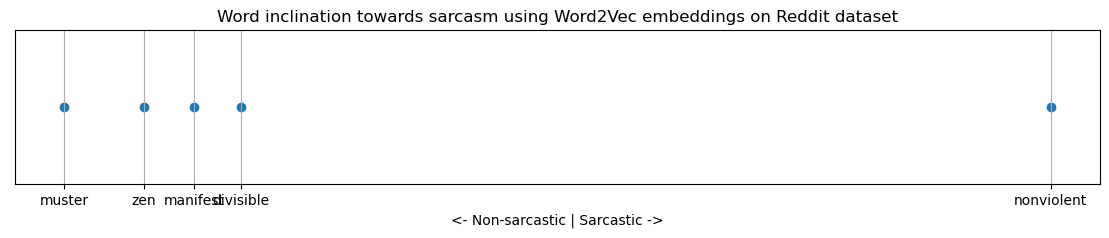

In [37]:
# Plotting the examples
import matplotlib.pyplot as plt
sarcasm_evaluations = [semantic_model.word_sentiment(word) for word in sample_words]
scores = [res[1] for res in sarcasm_evaluations]
# scores = [sentiment_w2v_axis[word] for word in sample_words]
y = [1] * len(scores)
print(scores)
plt.figure(figsize=(14,2))
plt.xlabel('<- Non-sarcastic | Sarcastic ->')
plt.title('Word inclination towards sarcasm using ' + model_name + ' embeddings on ' + dataset + ' dataset')
plt.scatter(scores, y)
plt.yticks([])
plt.xticks(scores, labels= sample_words)
plt.grid()
plt.savefig('../outputs/'+"_".join([dataset, model_name, 'semantic_axis'])+'.pdf', bbox_inches='tight')
plt.show()

### Sentiment Propagation

In [38]:
class SentimentPropagation:
    """
    Sentiment Propagation according to Hamilton et al (2016)
    https://doi.org/10.18653/v1/D16-1057
    """
    
    def __init__(self, model, words)#embedding_dict: Dict[str, np.ndarray]):
        """
        Args:
            model       Gensim Word embedding model
            words       List of keywords extracted from the dataset
        """
        self.word_index = dict()
        self.index_word = dict()
        self.embeddings = list()
        self.model = model
        self.words = words
        # for idx, item in enumerate(embedding_dict.items()):
        #     token, embedding = item
        #     self.embeddings.append(embedding)
        #     self.word_index[token] = idx
        
        # Create embedding list and word_index dict
        remove_list = []
        idx_corr = 0
        for idx, word in enumerate(self.words):
            try:
                self.embeddings.append(self.model[word])
                self.word_index[word] = idx - idx_corr
            except KeyError:
                idx_corr += 1
                remove_list.append(word)
                continue
        
        # Remove words without embeddings
        for del_word in remove_list:
            self.words.remove(del_word)

        self.embeddings = np.stack(self.embeddings)
        self.vocab_size = len(self.word_index)

        
    def edge_matrix(self, n_neighbors:int=10) -> np.ndarray:
        """
        Construct the graph edge matrix where:
        E[i, j] = arccos(-(w[i].T @ w[j]) / (norm(w[i]) * norm(w[j])))
        
        Args:
            n_neighbors (int) - The number of neighbors each vertex in the graph has
        Returns:
            (np.ndarray)      - The edge matrix
        """
        product = self.embeddings @ self.embeddings.T
        normed = np.linalg.norm(self.embeddings, axis=1).reshape(-1, 1)
        norm_product = normed @ normed.T
        arg = (product / norm_product)
        np.fill_diagonal(arg, 0)
        for idx, row in enumerate(arg):
            arg[idx, np.argsort(row)[:-20]] = 0
        return np.arccos(-arg.clip(-1, 1))
    
    def transition_matrix(self, edge_matrix: np.ndarray) -> np.ndarray:
        """
        Construct the transition matrix T from the edge matrix
        
        In contrast to the paper we use 1/s here (maybe an error in the paper?)
        
        Args:
            edge_matrix (np.ndarray) - edge_matrix
        Returns:
            (np.ndarray)             - The transition matrix
        """
        diag = np.diag([1/s if s > 0 else 0 for s in edge_matrix.sum(axis=0)])**(1/2)
        return diag @ edge_matrix @ diag
    
    def run(self, 
            T: np.ndarray, s: np.ndarray, p: np.ndarray, 
            beta: float, eps: float, max_iter: int) -> np.ndarray:
        """
        Update p until convergence
        
        Args:
            T (np.ndarray) - Transition matrix
            s (np.ndarray) - Seed vector
            p (np.ndarray) - Word-Sentiment vector
            beta (float)   - Local consistency vs. global consistency
            eps (float)    - Convergence criterium
            max_iter (int) - Convergence criterium
        Returns:
            p (np.ndarray) - Learned word-sentiment vector
        """
        for i in range(max_iter):
            new_p = (beta * T @ p + (1 - beta) * s)
            if np.abs(new_p - p).sum() < eps:
                break
            p = new_p
        return p
    
    def fit(self, 
              positive_seeds: List[str],
              negative_seeds: List[str], 
              beta: float=0.1, 
              n_neighbors: int=10, 
              eps:float=1e-6,
              max_iter:int=100) -> Dict[str, float]:
        """
        Learn sentiment scores
        
        Args:
            positive_seeds (List[str]) - A list of positive seed words (sarcastic)
            negative_seeds (List[str]) - A list of negative seed words (non-sarcastic)
            beta (float)               - Local consistency vs. global consistency
            n_neighbors (int)          - The number of neighbors each vertex in the graph has
            eps (float)                - Convergence criterium
            max_iter (int)             - Convergence criterium
        Returns:
            (Dict[str, float])         - A dictionary containing the learned sentiment scores
                                         with zero mean and unit variance
        """
        T = self.transition_matrix(self.edge_matrix(n_neighbors))
        
        s_positive = np.zeros(self.vocab_size)
        s_negative = np.zeros(self.vocab_size)
        
        s_positive[[self.word_index[seed] for seed in positive_seeds]] = 1 / len(positive_seeds)
        s_negative[[self.word_index[seed] for seed in negative_seeds]] = 1 / len(negative_seeds)
        
        p_positive = self.run(
            T, s_positive.reshape(-1, 1), 
            np.ones((self.vocab_size, 1)) / self.vocab_size, 
            beta, eps, max_iter
        )
        p_negative = self.run(
            T, s_negative.reshape(-1, 1),
            np.ones((self.vocab_size, 1)) / self.vocab_size,
            beta, eps, max_iter
        )
        
        score = p_positive / (p_positive + p_negative)
        # Make sure scores have zero mean and unit variance
        score = score - np.mean(score)
        score = score / np.std(score)
        
        # Construct dictionary
        sentiment = dict()
        for token, idx in self.word_index.items():
            sentiment[token] = score[idx].item()
            
        return sentiment